In [2]:
import pandas as pd
import sqlite3
import os

import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [3]:
# Open SQL Database and initialize dataframe
path = "../Algorithm/data"
conn = sqlite3.connect("C:\\Users\\charl\\Desktop\\Algorithm\\data\\Prediction.db")
orig_df = pd.read_sql_query("SELECT * FROM BLAZERS", conn)

In [4]:
# Add remaining teams to the end of the dataframe
teams = ["BLAZERS", "BUCKS", "BULLS", "CAVALIERS", "CELTICS", "CLIPPERS", "GRIZZLIES", "HAWKS", "HEAT", "HORNETS", "JAZZ", "KINGS", "KNICKS", "LAKERS", "MAGIC", "MAVERICKS", "NETS", "NUGGETS", "PACERS", "PELICANS", "PISTONS", "RAPTORS", "ROCKETS", "SIXERS", "SPURS", "SUNS", "THUNDER", "TIMBERWOLVES", "WARRIORS", "WIZARDS"]

for team in teams[1:]:
    temp_df = pd.read_sql_query("SELECT * FROM " + team, conn)
    orig_df = pd.concat([orig_df, temp_df], axis=0)

In [5]:
orig_df

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,TO_3,three_m3,three_a3,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg
0,21901289,2020-08-09,BLAZERS,SIXERS,7,4,12,52,14,6,...,10,5,16,183,1,245.0,115.0,116.1,110.7,108.4
1,21901280,2020-08-08,BLAZERS,CLIPPERS,8,8,15,71,3,7,...,7,7,22,191,1,239.0,115.0,116.1,116.3,109.9
2,21901261,2020-08-04,BLAZERS,ROCKETS,6,8,21,53,5,4,...,7,7,18,166,6,212.0,115.0,116.1,117.8,114.8
3,21901234,2020-07-31,BLAZERS,GRIZZLIES,6,6,14,65,5,9,...,7,7,14,189,3,275.0,115.0,116.1,112.6,113.7
4,21900966,2020-03-10,BLAZERS,SUNS,6,7,15,64,8,8,...,7,6,17,160,4,236.4,115.0,116.1,113.6,113.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,21300189,2013-11-23,WIZARDS,KNICKS,9,5,11,53,1,4,...,5,4,18,145,7,187.0,100.7,99.4,98.6,99.4
284,21300156,2013-11-19,WIZARDS,TIMBERWOLVES,5,5,11,61,7,2,...,9,4,12,162,0,204.0,100.7,99.4,106.9,104.3
285,21300138,2013-11-16,WIZARDS,CAVALIERS,16,2,10,43,7,8,...,5,1,6,133,5,199.0,100.7,99.4,98.2,101.5
286,21300077,2013-11-08,WIZARDS,NETS,4,6,13,60,6,9,...,12,1,13,146,0,220.0,100.7,99.4,98.5,99.5


In [6]:
orig_df.head()

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,TO_3,three_m3,three_a3,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg
0,21901289,2020-08-09,BLAZERS,SIXERS,7,4,12,52,14,6,...,10,5,16,183,1,245.0,115.0,116.1,110.7,108.4
1,21901280,2020-08-08,BLAZERS,CLIPPERS,8,8,15,71,3,7,...,7,7,22,191,1,239.0,115.0,116.1,116.3,109.9
2,21901261,2020-08-04,BLAZERS,ROCKETS,6,8,21,53,5,4,...,7,7,18,166,6,212.0,115.0,116.1,117.8,114.8
3,21901234,2020-07-31,BLAZERS,GRIZZLIES,6,6,14,65,5,9,...,7,7,14,189,3,275.0,115.0,116.1,112.6,113.7
4,21900966,2020-03-10,BLAZERS,SUNS,6,7,15,64,8,8,...,7,6,17,160,4,236.4,115.0,116.1,113.6,113.4


In [7]:
orig_df['avg_points_scored'] = (orig_df['home_ppg'] + orig_df['away_ppg'])/2
orig_df['avg_points_allowed'] = (orig_df['home_oppg'] + orig_df['away_oppg'])/2
orig_df["TO_2"] = orig_df["TO_2"] + orig_df["TO_1"]
orig_df['TO_3'] = orig_df["TO_3"] + orig_df["TO_2"]
orig_df["three_a2"] = orig_df["three_a2"] + orig_df["three_a1"]
orig_df['three_a3'] = orig_df["three_a3"] + orig_df["three_a2"]
orig_df["three_m2"] = orig_df["three_m2"] + orig_df["three_m1"]
orig_df['three_m3'] = orig_df["three_m3"] + orig_df["three_m2"]
orig_df['percent_3pt'] = orig_df['three_m3']/orig_df['three_a3']
orig_df['percent_3pt'] = orig_df['three_m3']/orig_df['three_a3']

In [8]:
orig_df.head()

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,avg_points_scored,avg_points_allowed,percent_3pt
0,21901289,2020-08-09,BLAZERS,SIXERS,7,4,12,52,14,13,...,183,1,245.0,115.0,116.1,110.7,108.4,112.85,112.25,0.340909
1,21901280,2020-08-08,BLAZERS,CLIPPERS,8,8,15,71,3,15,...,191,1,239.0,115.0,116.1,116.3,109.9,115.65,113.00,0.438596
2,21901261,2020-08-04,BLAZERS,ROCKETS,6,8,21,53,5,10,...,166,6,212.0,115.0,116.1,117.8,114.8,116.40,115.45,0.403226
3,21901234,2020-07-31,BLAZERS,GRIZZLIES,6,6,14,65,5,15,...,189,3,275.0,115.0,116.1,112.6,113.7,113.80,114.90,0.391304
4,21900966,2020-03-10,BLAZERS,SUNS,6,7,15,64,8,14,...,160,4,236.4,115.0,116.1,113.6,113.4,114.30,114.75,0.367347


In [9]:
orig_df.columns

Index(['game_ID', 'game_date', 'home_team', 'away_team', 'TO_1', 'three_m1',
       'three_a1', 'ts_1', 'diff_1', 'TO_2', 'three_m2', 'three_a2', 'ts_2',
       'diff_2', 'TO_3', 'three_m3', 'three_a3', 'ts_3', 'diff_3', 'ts_final',
       'home_ppg', 'home_oppg', 'away_ppg', 'away_oppg', 'avg_points_scored',
       'avg_points_allowed', 'percent_3pt'],
      dtype='object')

In [34]:
features = ["diff_3", "ts_3", "avg_points_scored", "avg_points_allowed", "ts_final"]

In [35]:
df = orig_df[features]

In [36]:
df.sample(20)

,diff_3,ts_3,avg_points_scored,avg_points_allowed,ts_final
116,7,121,107.30,110.20,186.0
110,5,159,105.25,108.10,225.0
185,10,158,100.85,104.85,215.0
22,6,166,105.05,110.20,203.0
157,13,163,108.65,108.95,201.0
67,2,146,109.45,115.15,193.0
259,3,157,106.55,102.05,203.0
229,19,149,107.00,100.85,208.0
179,23,143,100.35,103.80,183.0
63,4,168,113.20,111.55,194.0


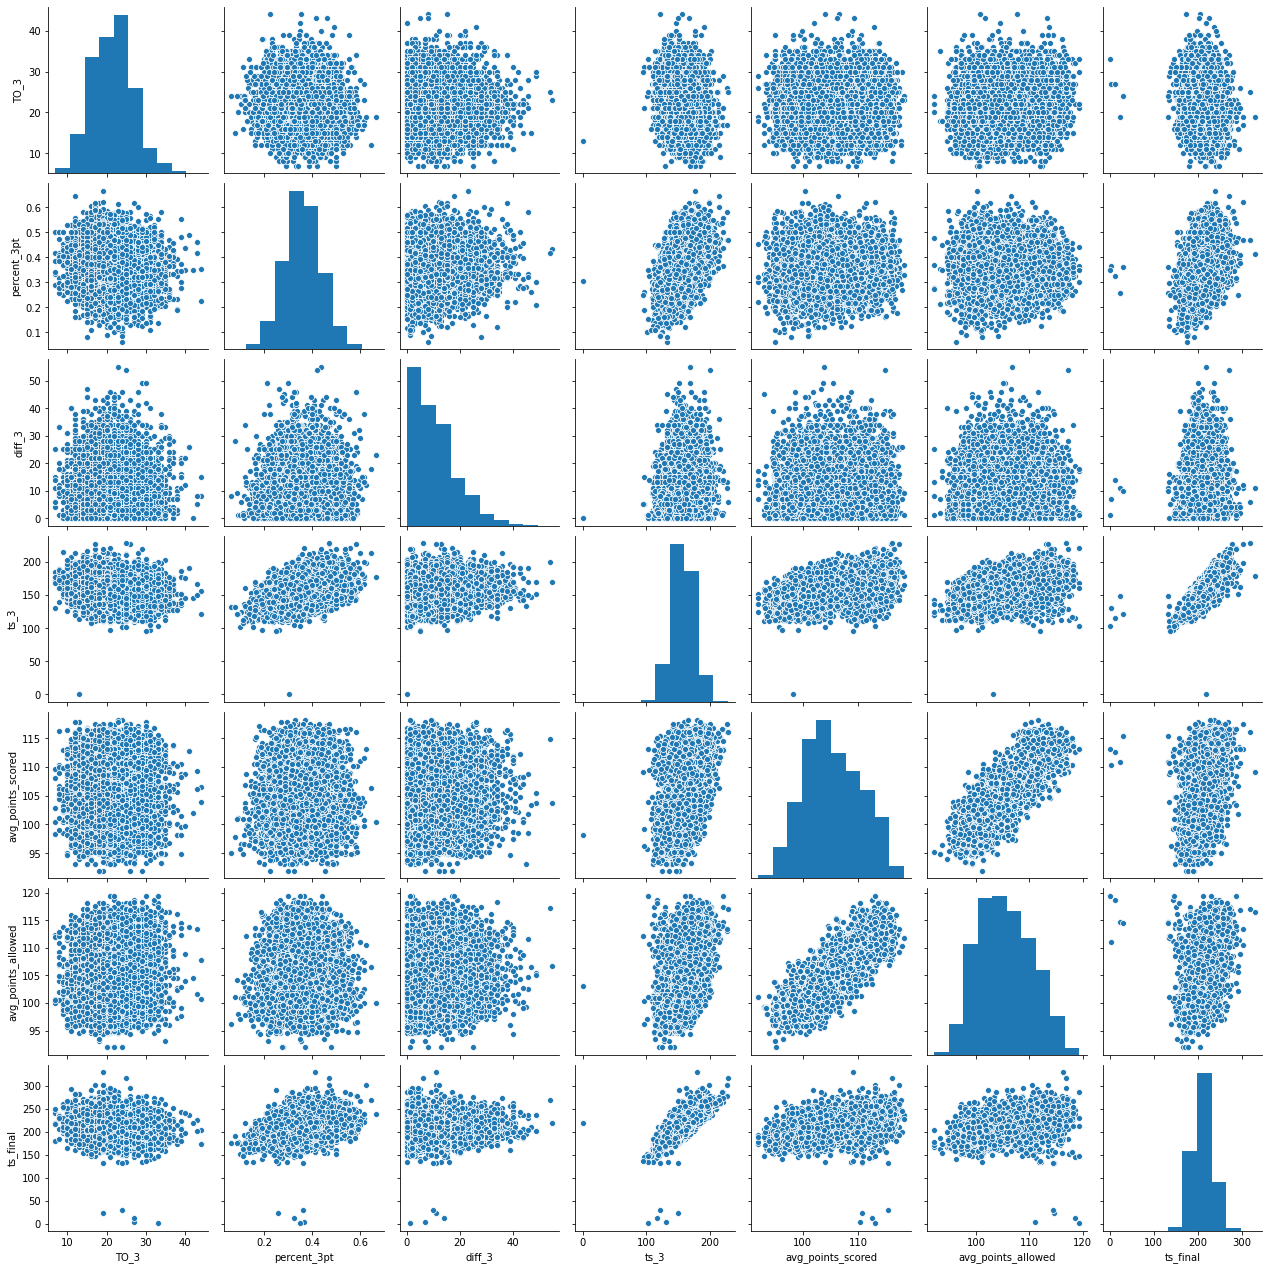

In [13]:
sns.pairplot(df)

,TO_3,percent_3pt,diff_3,ts_3,avg_points_scored,avg_points_allowed,ts_final
TO_3,1.000000,-0.052852,0.032346,-0.118337,0.016893,0.039984,-0.105289
percent_3pt,-0.052852,1.000000,0.053632,0.460480,0.027107,0.005841,0.360853
diff_3,0.032346,0.053632,1.000000,0.094477,0.033525,0.024482,0.044270
ts_3,-0.118337,0.460480,0.094477,1.000000,0.479098,0.457177,0.853779
avg_points_scored,0.016893,0.027107,0.033525,0.479098,1.000000,0.795377,0.455420
avg_points_allowed,0.039984,0.005841,0.024482,0.457177,0.795377,1.000000,0.438504
ts_final,-0.105289,0.360853,0.044270,0.853779,0.455420,0.438504,1.000000


<AxesSubplot:>

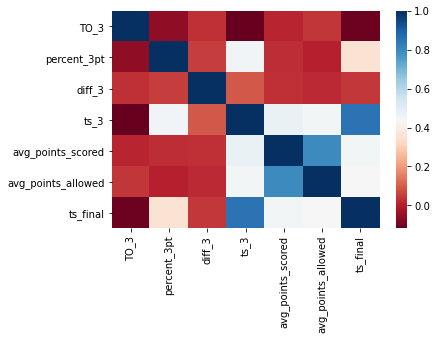

In [14]:
# check for multicolinearity
corr = df.corr()
display(corr)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [15]:
# Heatmap tells us that score_rate, time_remaining, and score_diff are uncorrelated enough to include. 

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(df)


# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)


# display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                 538.380658
TO_3                    1.029403
percent_3pt             1.374722
diff_3                  1.016325
ts_3                    4.507452
avg_points_scored       2.878516
avg_points_allowed      2.835557
ts_final                3.759566
dtype: float64

In [16]:
# Given all of our variables have low correlation values (well under 5), we can confirm they are okay to be included
desc = df.describe()
desc

,TO_3,percent_3pt,diff_3,ts_3,avg_points_scored,avg_points_allowed,ts_final
count,8527.000000,8527.000000,8527.000000,8527.000000,8527.000000,8527.000000,8527.000000
mean,21.556116,0.360140,10.454322,157.555060,105.441586,105.461997,210.297432
std,5.095647,0.077723,8.114735,17.449985,5.149629,5.000067,22.361762
min,7.000000,0.062500,0.000000,0.000000,91.950000,92.050000,0.800000
25%,18.000000,0.307692,4.000000,146.000000,101.550000,101.500000,195.000000
50%,21.000000,0.360000,9.000000,157.000000,104.950000,105.100000,209.000000
75%,25.000000,0.411765,15.000000,169.000000,109.450000,109.150000,225.000000
max,44.000000,0.666667,55.000000,228.000000,118.250000,119.400000,329.000000


In [37]:
#df = df[df['diff_1'] < 29]
df = df[df['ts_final'] > 100]
df = df[df['ts_final'] < 300]


In [38]:
#build the model
X = df.drop('ts_final', axis = 1)
Y = df["ts_final"]

#Split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# Fit the model
regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

LinearRegression()

In [39]:
# Print out results of the model
intercept = regression_model.intercept_
coefficent = regression_model.coef_[0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

for coef in zip(X.columns, regression_model.coef_):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 9.57
----------------------------------------------------------------------------------------------------
The Coefficient for diff_3 is -0.092
The Coefficient for ts_3 is 1.0
The Coefficient for avg_points_scored is 0.15
The Coefficient for avg_points_allowed is 0.22


In [40]:
Y_predict = regression_model.predict(X_test)

In [41]:
Y_predict

array([199.47015031, 215.14592485, 202.8486816 , 230.08828576,
       187.0843507 , 196.75126493, 194.77192501, 188.90759896,
       183.91643999, 216.65655158, 222.81816471, 221.74553804,
       239.47976512, 198.57974765, 197.14746736, 175.81336496,
       202.14461246, 196.22080011, 203.58145386, 215.17352391,
       225.64484488, 192.96144038, 223.78527026, 218.68853579,
       204.40501075, 220.49846095, 223.01237948, 203.40226191,
       227.29777938, 246.03826754, 205.52931863, 209.19076207,
       198.4205165 , 213.34755233, 199.22050676, 225.5259007 ,
       239.40520853, 184.82468587, 201.19179756, 196.09486006,
       251.38802353, 221.24369588, 217.68082447, 217.28174649,
       212.01457691, 213.03149325, 195.05126814, 247.31242086,
       230.09662579, 215.82310167, 225.70225623, 222.56964269,
       230.22730971, 233.23678242, 178.60954865, 196.33556091,
       203.98033216, 211.72433012, 199.39791596, 240.76460975,
       211.79641294, 216.31617374, 234.21232146, 216.33

In [42]:
print('Train Score :', regression_model.score(X_train,Y_train))
print('Test Score:', regression_model.score(X_test,Y_test))

Train Score : 0.7523337086401676
Test Score: 0.7791400574295405


In [43]:
# Applying model to be used with the statsmodel package (needs a constant) 
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)


# fit the data
est = model.fit()
est.pvalues

const                 4.389866e-04
diff_3                1.537594e-11
ts_3                  0.000000e+00
avg_points_scored     6.725335e-05
avg_points_allowed    1.840929e-08
dtype: float64

In [44]:
#White's test for heteroscedasticity
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

0.0 0.0
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 0.0
7.647542824551903e-20 5.993109512930041e-20
----------------------------------------------------------------------------------------------------


In [45]:
model = sm.OLS(Y, X2)
est = model.fit()

_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)

0.0 0.0


C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The lowest p-value found was 0.006352
We reject the null hypthoesis, so there is autocorrelation.
----------------------------------------------------------------------------------------------------


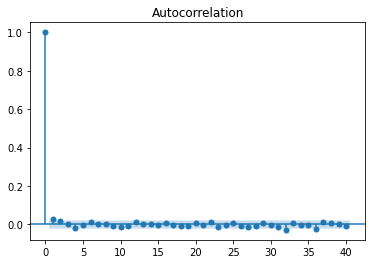

In [46]:
# test for autocorrelation

from statsmodels.stats.stattools import durbin_watson

test_results = diag.acorr_ljungbox(est.resid)
ibvalue, p_val = test_results

if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)
    
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

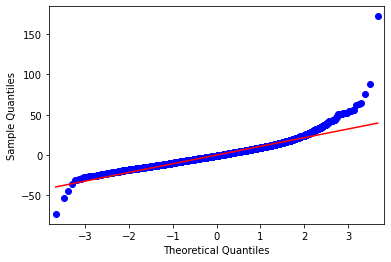

The mean of the residuals is 4.719e-13


In [47]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [48]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(Y_test, Y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(Y_test, Y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 94.8
MAE 7.56
RMSE 9.74


In [49]:
model_r2 = r2_score(Y_test, Y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.78


In [50]:
est.conf_int()

,0,1
const,4.019050,14.141509
diff_3,-0.125875,-0.069242
ts_3,1.019768,1.050213
avg_points_scored,0.077614,0.227690
avg_points_allowed,0.143095,0.295894


In [51]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               ts_final   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     6551.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:07:03   Log-Likelihood:                -32331.
No. Observations:                8518   AIC:                         6.467e+04
Df Residuals:                    8513   BIC:                         6.471e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.0803      2

In [52]:
import csv
with open('../training_combinations/quarter_3_stats.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    row = [features, model_mse, model_mae, model_rmse, model_r2, ""]
    writer.writerow(row)

In [53]:
import pickle

# pickle the model
with open('../Models/predict_3.sav','wb') as f:
     pickle.dump(regression_model, f)